In [2]:
import pandas as pd
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import os
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, Normalizer, StandardScaler, MinMaxScaler, RobustScaler,OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,mean_squared_error,r2_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.model_selection import GridSearchCV


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.gaussian_process import GaussianProcessClassifier


In [3]:
filtered_df = pd.read_csv("/home/ujx4ab/ondemand/WindTurbine_KL_Divergence/Data/combined_data.csv")

In [4]:
filtered_df.head()

,timestamp,ambient_temperature,wind_relative_direction,wind_speed,total_active_power,generator_rpm,rotor_rpm,gearbox_temp_bin,pitch_angle_bin
0,2022-08-03 06:10:00,22.0,129.4,1.7,-1280.0,35.3,0.0,<45,0.0
1,2022-08-03 06:20:00,22.0,133.6,1.7,-1278.0,0.0,0.0,<45,0.0
2,2022-08-03 06:30:00,22.0,167.1,0.9,-1356.0,2.8,0.0,<45,0.0
3,2022-08-03 06:40:00,22.0,-49.1,1.5,-1274.0,0.4,0.0,<45,0.0
4,2022-08-03 06:50:00,22.0,-107.3,1.0,-1284.0,0.0,0.0,<45,0.0


/tmp/ipykernel_427690/1563739152.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  complete_range = pd.date_range(start=missing_data_check_df.index.min(), end=missing_data_check_df.index.max(), freq='10T')


Total expected timestamps: 99323
Total missing timestamps: 2213


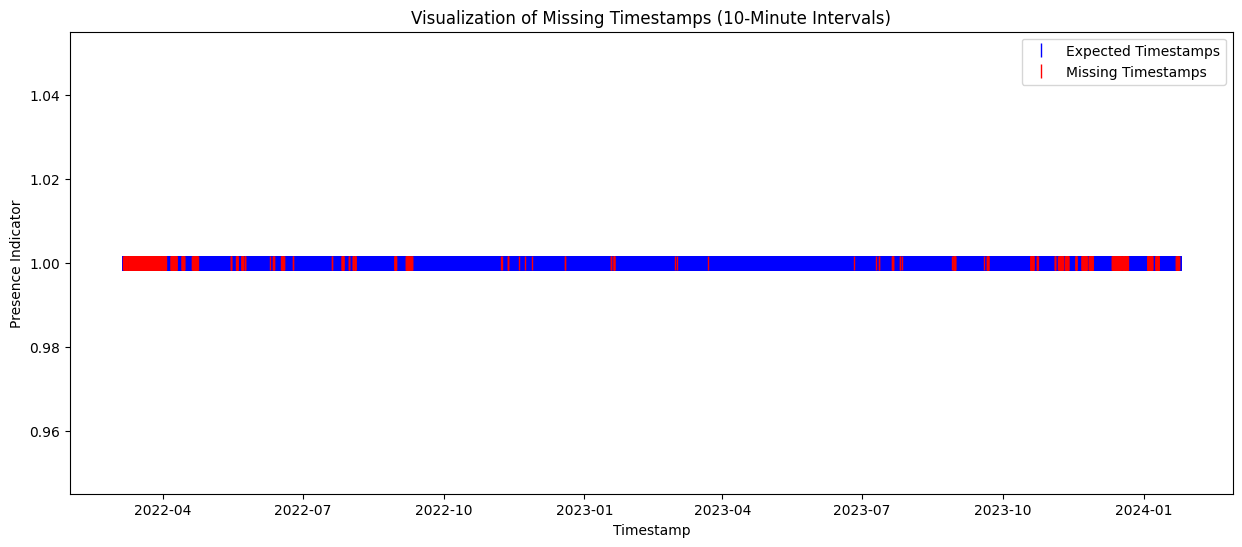

In [5]:
# Display chunks of missing data
missing_data_check_df = filtered_df.copy()
missing_data_check_df['timestamp'] = pd.to_datetime(missing_data_check_df['timestamp'])
missing_data_check_df.set_index('timestamp', inplace=True)
complete_range = pd.date_range(start=missing_data_check_df.index.min(), end=missing_data_check_df.index.max(), freq='10T')
missing_timestamps = complete_range.difference(missing_data_check_df.index)

print("Total expected timestamps:", len(complete_range))
print("Total missing timestamps:", len(missing_timestamps))

plt.figure(figsize=(15, 6))
plt.plot(complete_range, [1] * len(complete_range), '|', color='blue', markersize=10, label='Expected Timestamps')

if len(missing_timestamps) > 0:
    plt.plot(missing_timestamps, [1] * len(missing_timestamps), '|', color='red', markersize=10, label='Missing Timestamps')

plt.xlabel('Timestamp')
plt.ylabel('Presence Indicator')
plt.title('Visualization of Missing Timestamps (10-Minute Intervals)')
plt.legend()
plt.show()

In [6]:
filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'])

# Extract Month from the timestamp
filtered_df['Month'] = filtered_df['timestamp'].dt.month

# Map months to seasons
seasons_dict = {
    1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn',
    11: 'Autumn', 12: 'Winter'
}
filtered_df['Seasons'] = filtered_df['Month'].map(seasons_dict)

# Extract Hour from the timestamp
filtered_df['Hour'] = filtered_df['timestamp'].dt.hour + 1

# Check for missing data
missing_data = filtered_df.isna().sum()
print("Missing Values in Each Column:")
print(missing_data)


Missing Values in Each Column:
timestamp                  0
ambient_temperature        0
wind_relative_direction    0
wind_speed                 0
total_active_power         0
generator_rpm              0
rotor_rpm                  0
gearbox_temp_bin           0
pitch_angle_bin            0
Month                      0
Seasons                    0
Hour                       0
dtype: int64


In [7]:
filtered_df.columns

Index(['timestamp', 'ambient_temperature', 'wind_relative_direction',
       'wind_speed', 'total_active_power', 'generator_rpm', 'rotor_rpm',
       'gearbox_temp_bin', 'pitch_angle_bin', 'Month', 'Seasons', 'Hour'],
      dtype='object')

In [8]:
#Intialize Numerical and Date Columns
date_col=['Month','Seasons','Hour']
num_col= ['timestamp', 'ambient_temperature', 'wind_relative_direction',
       'wind_speed', 'total_active_power', 'generator_rpm', 'rotor_rpm',
       'gearbox_temp_bin', 'pitch_angle_bin']

array([[<Axes: title={'center': 'timestamp'}>,
        <Axes: title={'center': 'ambient_temperature'}>,
        <Axes: title={'center': 'wind_relative_direction'}>],
       [<Axes: title={'center': 'wind_speed'}>,
        <Axes: title={'center': 'total_active_power'}>,
        <Axes: title={'center': 'generator_rpm'}>],
       [<Axes: title={'center': 'rotor_rpm'}>,
        <Axes: title={'center': 'pitch_angle_bin'}>, <Axes: >]],
      dtype=object)

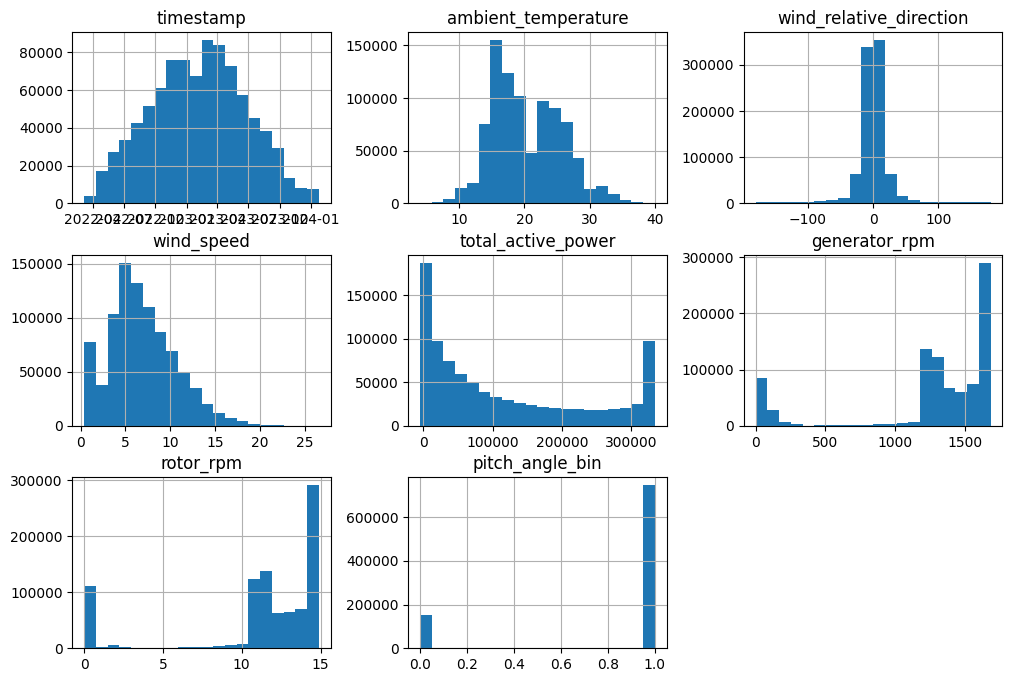

In [9]:
filtered_df[num_col].hist(bins=20,figsize=(12,8))

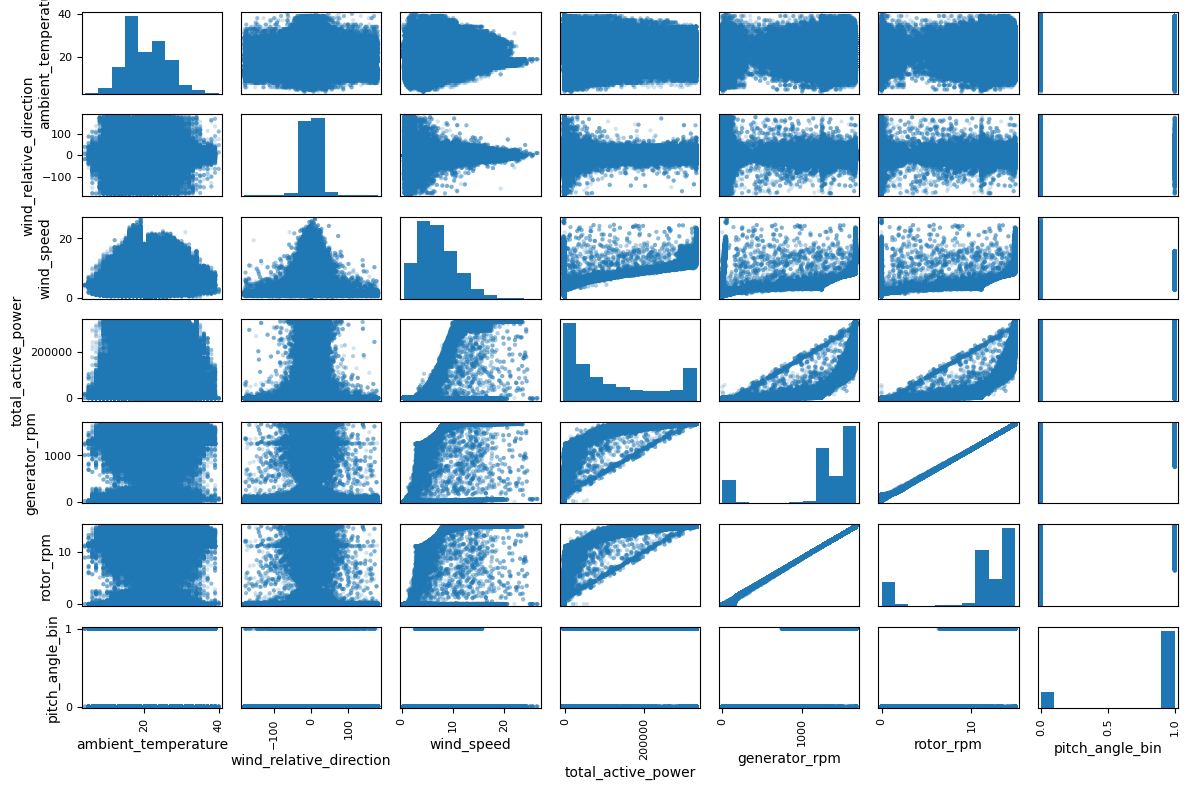

In [10]:
pd.plotting.scatter_matrix(filtered_df[num_col], alpha=0.2, figsize=(12, 8))
plt.tight_layout()
plt.show()

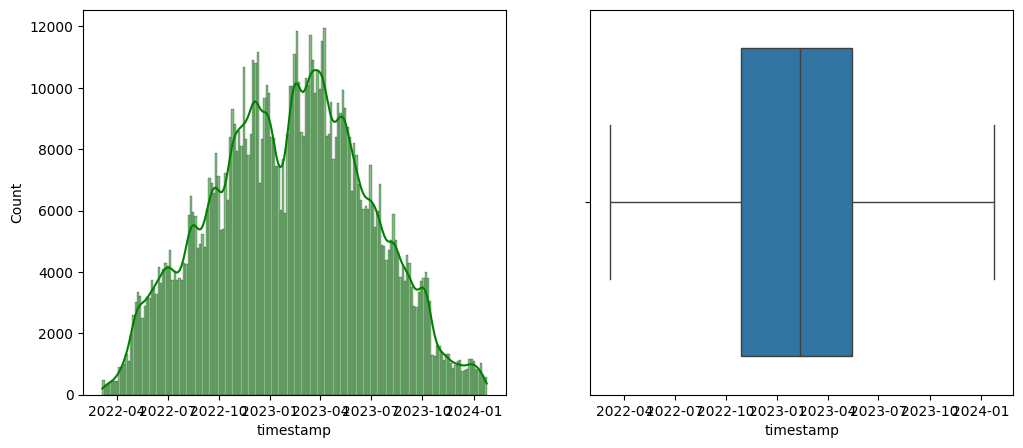

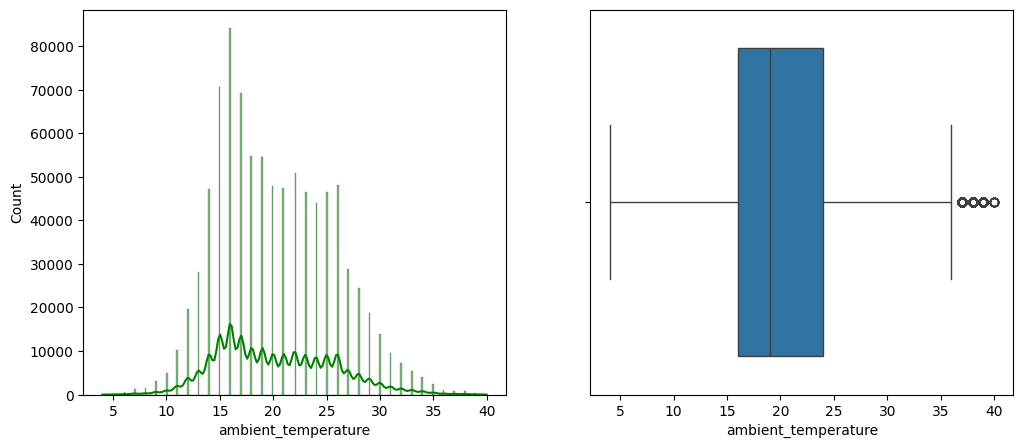

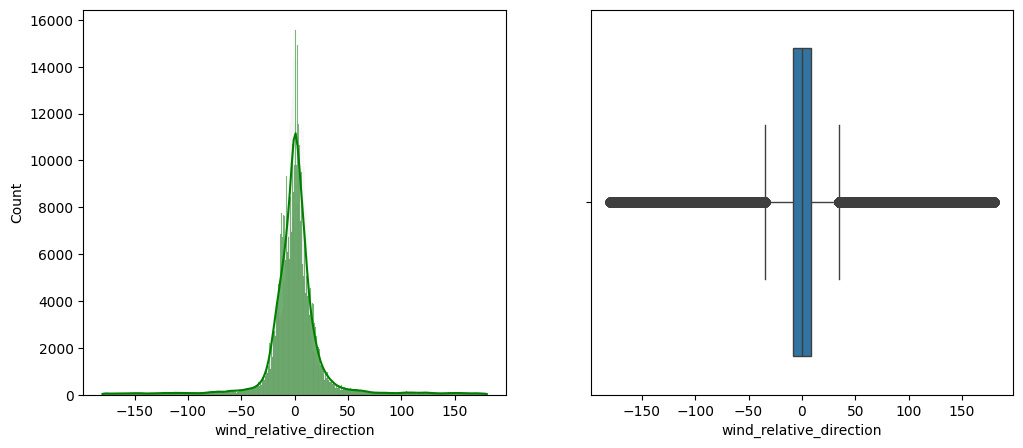

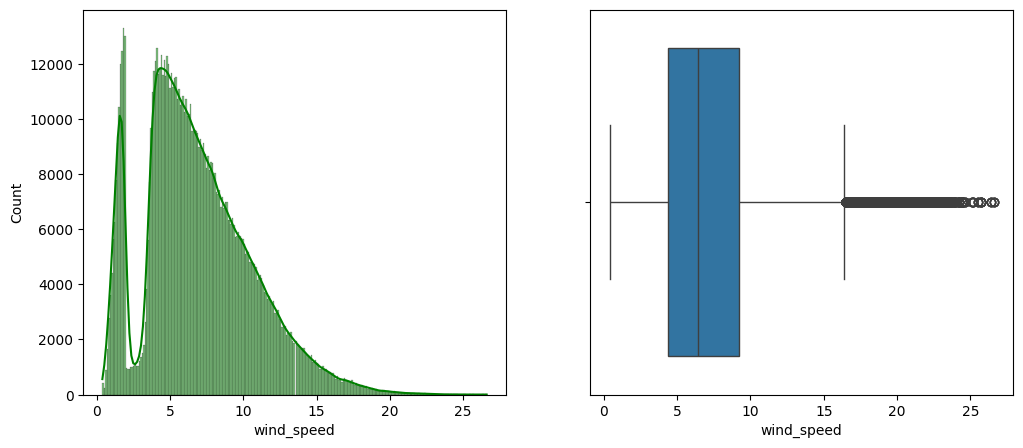

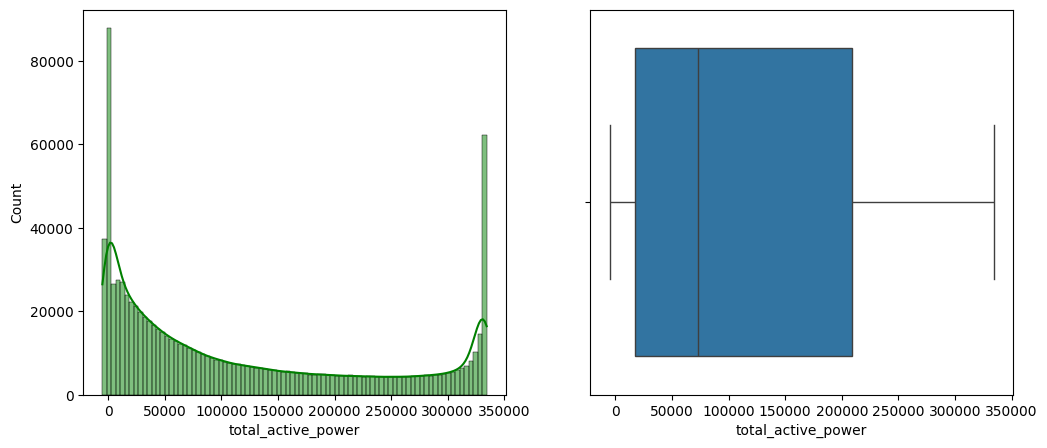

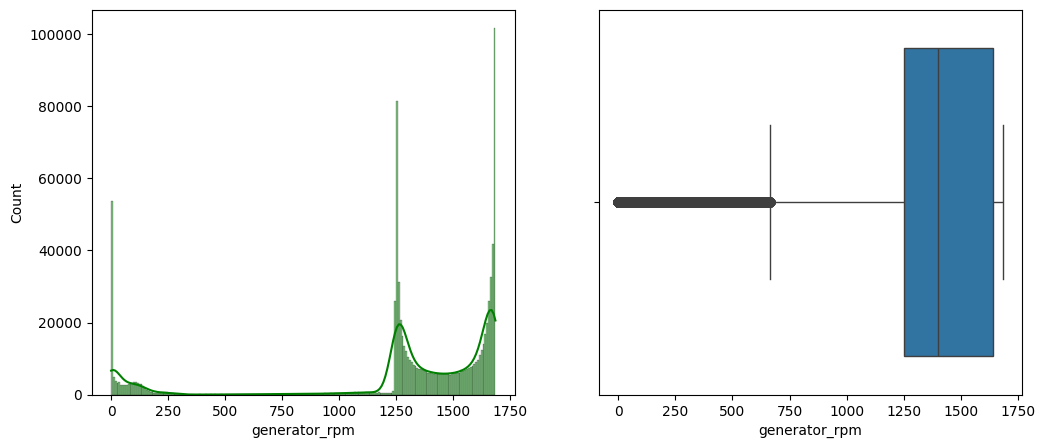

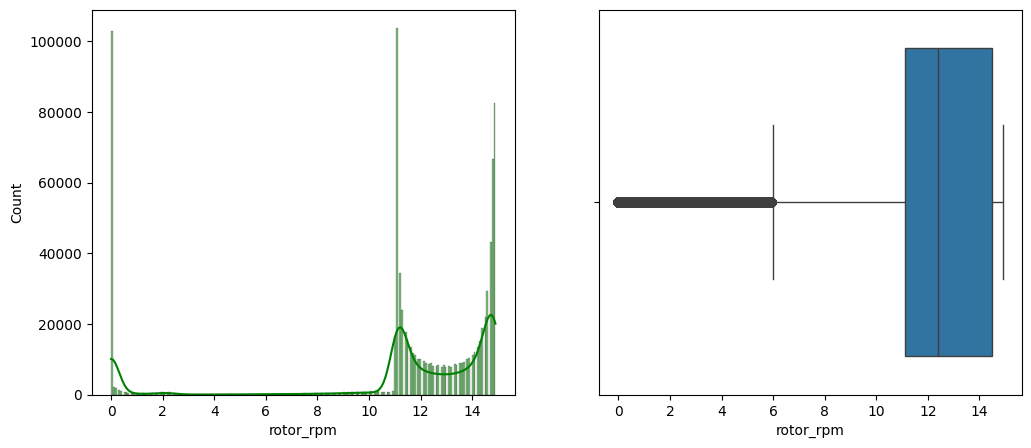

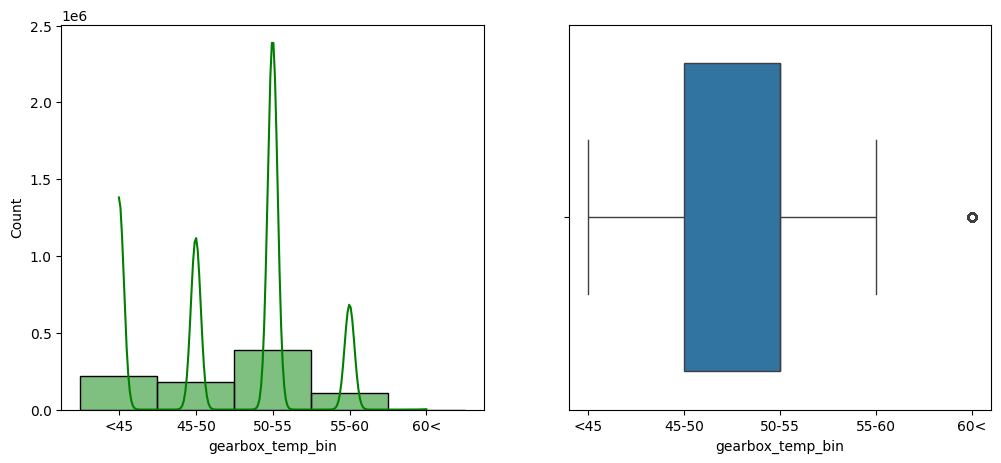

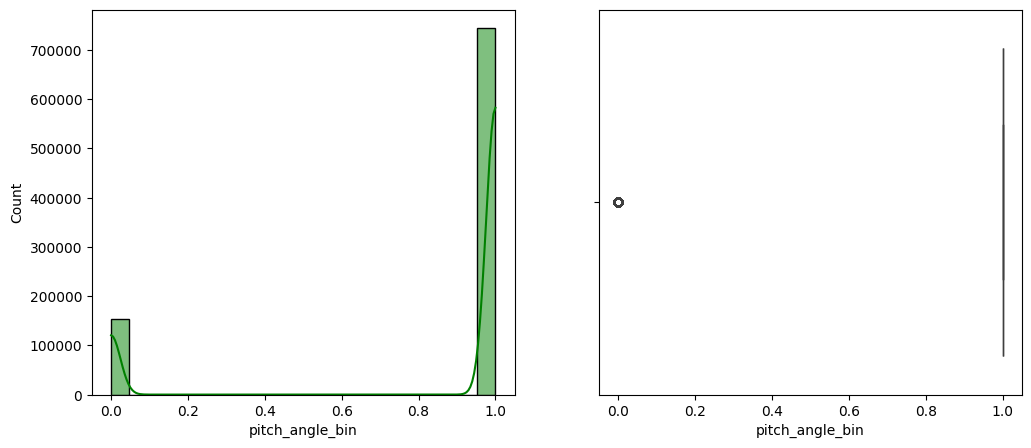

In [11]:
for col in num_col:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(filtered_df[col], kde=True, ax=ax[0], color='green')
    sns.boxplot(x=filtered_df[col], ax=ax[1])
    plt.show()

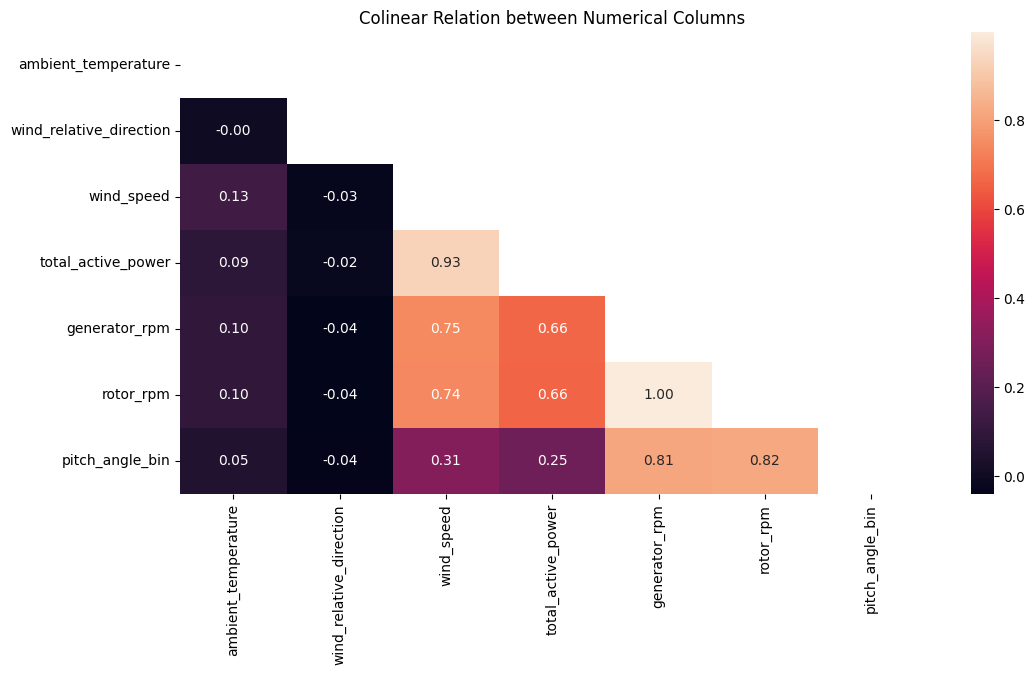

In [12]:
corr = filtered_df[num_col].corr(numeric_only=True)
mask = np.triu(corr)
mask=mask
plt.figure(figsize=(12, 6))
plt.title('Colinear Relation between Numerical Columns')
sns.heatmap(corr, annot=True,mask=mask, fmt='.2f')
sns.color_palette("magma", as_cmap=True)
plt.show()

/tmp/ipykernel_427690/729679423.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_427690/729679423.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_427690/729679423.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_427690/729679423.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_427690/729679423.py:7: FutureWarning: 

P

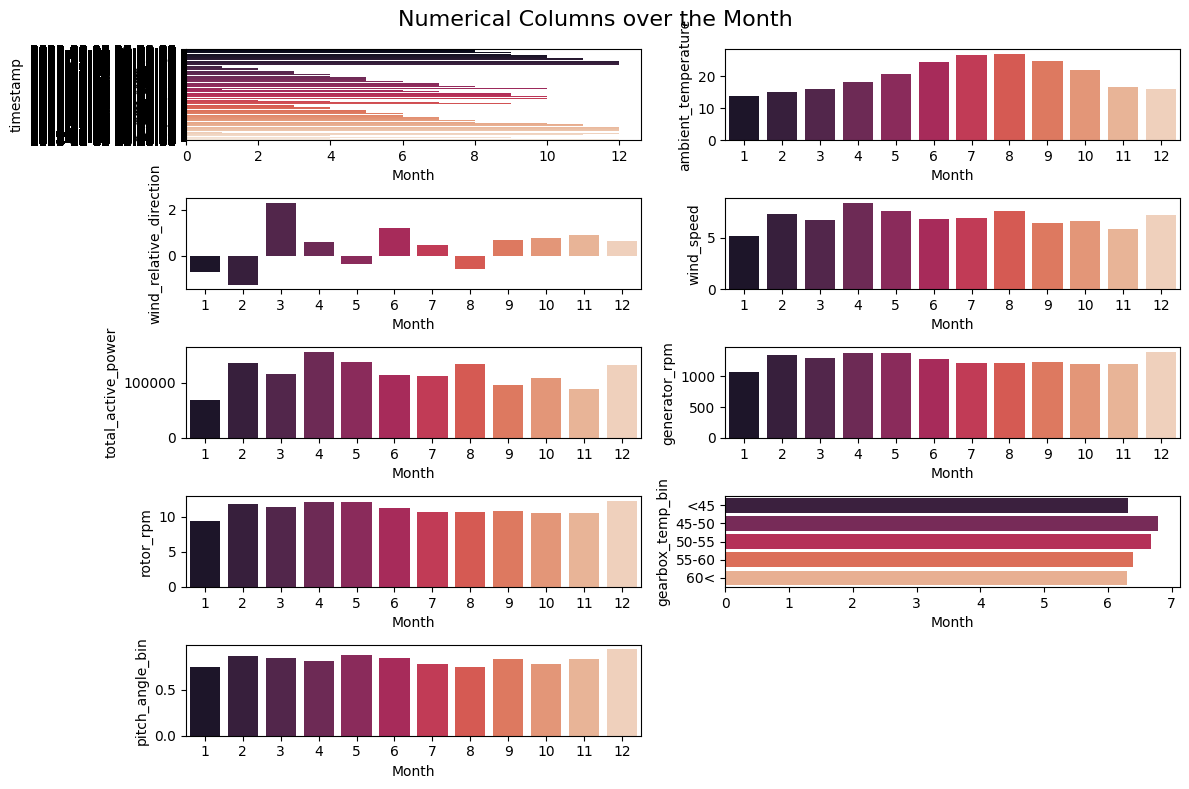

/tmp/ipykernel_427690/729679423.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_427690/729679423.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_427690/729679423.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_427690/729679423.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_427690/729679423.py:7: FutureWarning: 

P

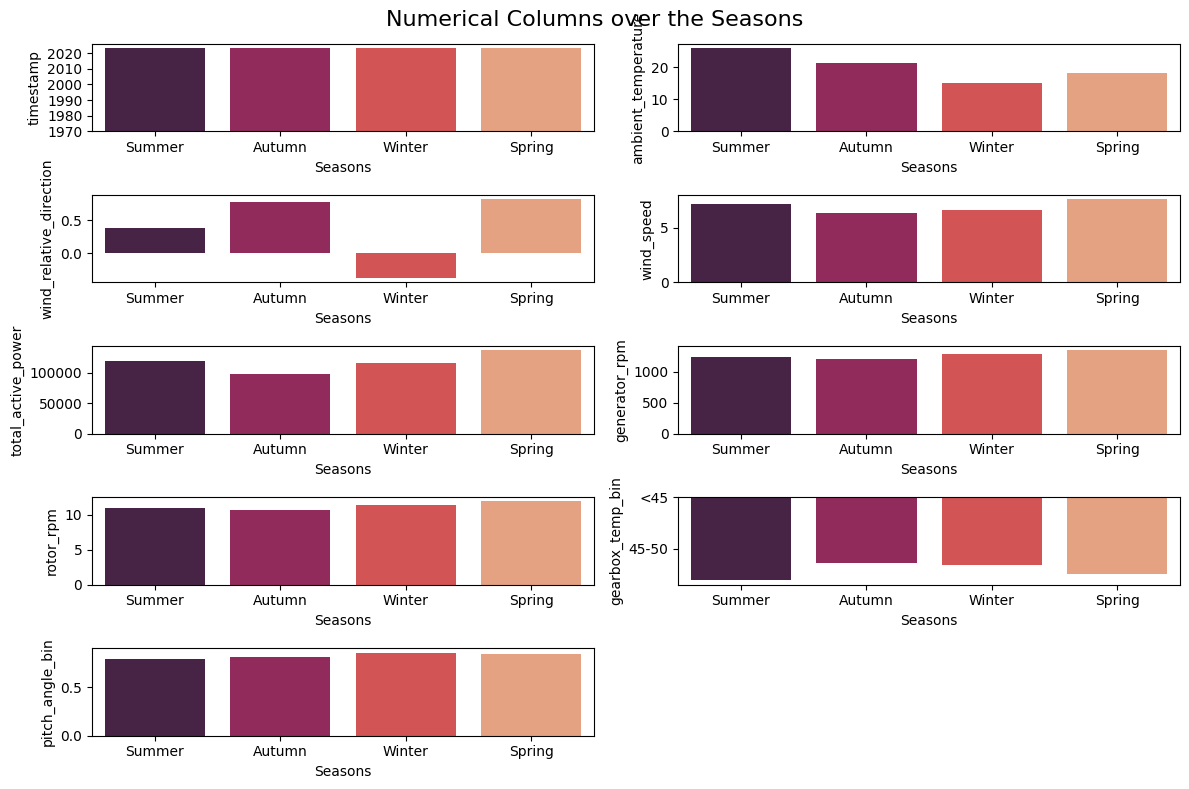

/tmp/ipykernel_427690/729679423.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_427690/729679423.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_427690/729679423.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_427690/729679423.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_427690/729679423.py:7: FutureWarning: 

P

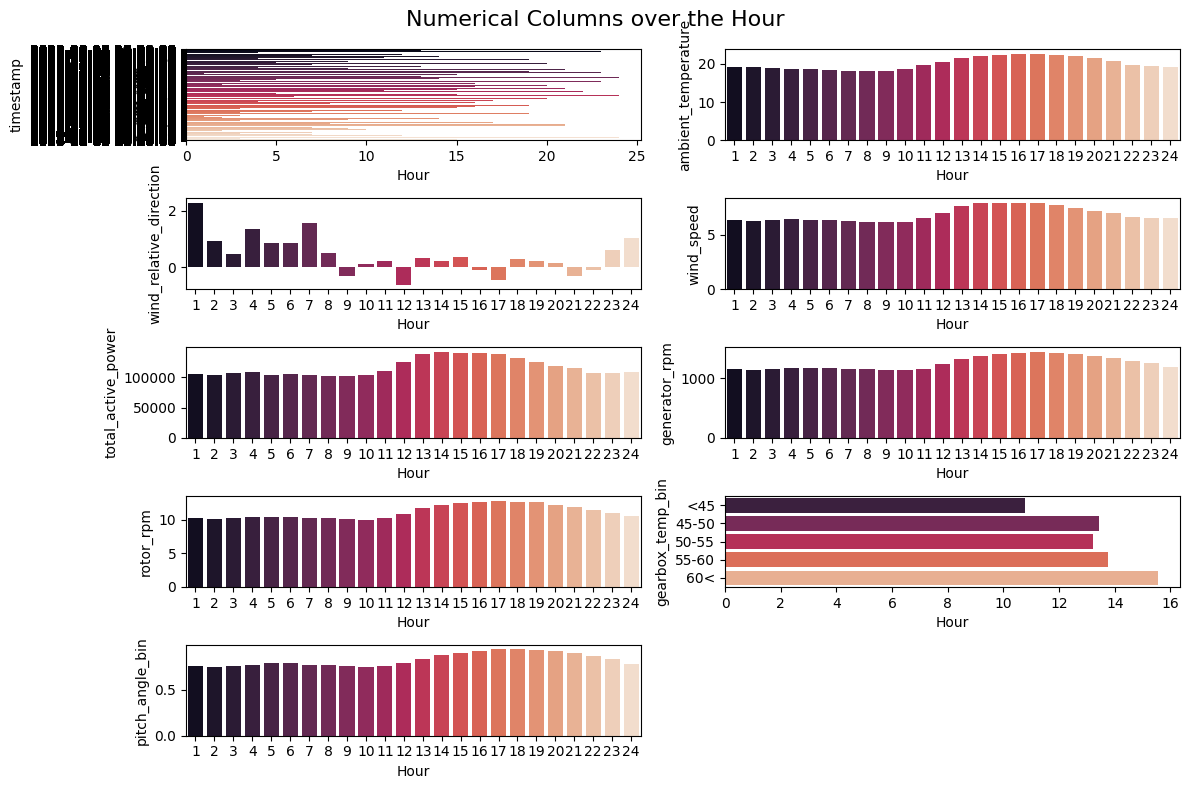

In [13]:
def create_num_col_vs_date_col(date_col, num_col): 
    for date in date_col:
        num_rows = math.ceil(len(num_col) / 2)  # Round up to ensure enough rows
        fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 8))
        axes = axes.flatten()
        for idx, numeric_feature in enumerate(num_col):
            sns.barplot(
                x=date, 
                y=numeric_feature, 
                data=filtered_df, 
                ax=axes[idx], 
                errorbar=None, 
                palette='rocket'
            )
        for i in range(len(num_col), len(axes)):
            fig.delaxes(axes[i])

        fig.suptitle(f'Numerical Columns over the {date}', fontsize=16)
        plt.tight_layout()
        plt.show()

create_num_col_vs_date_col(date_col, num_col)